Run cells in order to train importance sampler models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
from pickle import load
import tensorflow as tf
from tensorflow import keras
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

tf.random.set_seed(42)
K = keras.backend

from sklearn.preprocessing import StandardScaler,PowerTransformer
import math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import os
import pandas as pd
import pickle
from helper import *


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
K.set_floatx("float32")

Run the below cell if using a GPU.

In [ ]:
#using laptop gpu
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
k = 8
J = 32
save_time_step = 0.005
h=1 
F=20
c=10
b=10

# Prepare data #

In [4]:
history_length = 100
test_seq_length = 1000

In [5]:
#load train, validation and test datasets 
train_dataset = np.load("../../data/truth_run/training_dataset.npy")
valid_dataset = np.load("../../data/truth_run/val_dataset.npy")

In [6]:
x_train = train_dataset[:,:,0]
x_valid = valid_dataset[:,:,0]

In [7]:
##### Functions to work out the exact U for each x #########

def _rhs_X_dt(X, U,dt=0.005):
    """Compute the right hand side of the X-ODE."""

    dXdt = (-np.roll(X, 1,axis=1) * (np.roll(X, 2,axis=1) - np.roll(X, -1,axis=1)) -
                X + F - U)

    return dt * dXdt 


def U(Xt,Xt_1,dt=0.005):
    k1_X = _rhs_X_dt(Xt, U=0)
    k2_X = _rhs_X_dt(Xt + k1_X / 2, U=0)
    Xt_1_pred = k2_X + Xt 
    #print(Xt_1_pred)
    Ut = (Xt_1_pred - Xt_1 )/dt

    return Ut

In [8]:
u_t = U(x_train[:-1,:],x_train[1:,:])    
u_t_valid = U(x_valid[:-1,:],x_valid[1:,:])  

In [9]:
training_dataset = np.stack([x_train[:-1],u_t],axis=2)
valid_dataset = np.stack([x_valid[:-1],u_t_valid],axis=2)


In [10]:
def prepare_datasets_for_RNN(dataset,history_length):
    max_index = (dataset.shape[0]-1)//history_length
    dataset = dataset[:(max_index*history_length +1),:,:] 
    dataset_shape = dataset.shape[0]
    last_elements = dataset[-1,:,:]
    remaining_dataset = dataset[:-1,:,:]
    reshaped = remaining_dataset.reshape(-1,history_length,k,2)
    add_on = reshaped[1:,:1,:,:]
    last_elements = last_elements.reshape(1,1,k,2)
    add_on_combined = np.concatenate((add_on,last_elements),axis=0)
    concat = np.concatenate((reshaped,add_on_combined),axis=1)
    concat = concat.transpose((2,0,1,3)).reshape((-1,history_length+1,2),order="F")
    return concat.astype("float32")

In [11]:
train_nn_features = prepare_datasets_for_RNN(training_dataset,history_length)
valid_nn_features = prepare_datasets_for_RNN(valid_dataset,test_seq_length)

In [12]:
x_mean = np.mean(train_nn_features[:,:,0])
x_std = np.std(train_nn_features[:,:,0])
u_mean = np.mean(train_nn_features[:,:,1])
u_std = np.std(train_nn_features[:,:,1])

In [13]:
#scaling
train_nn_features[:,:,0] = (train_nn_features[:,:,0] - x_mean)/x_std
train_nn_features[:,:,1] = (train_nn_features[:,:,1] - u_mean)/u_std

In [14]:
#scaling
valid_nn_features[:,:,0] = (valid_nn_features[:,:,0] - x_mean)/x_std
valid_nn_features[:,:,1] = (valid_nn_features[:,:,1] - u_mean)/u_std

In [15]:
#train_nn_features_tf = tf.convert_to_tensor(train_nn_features)
valid_nn_features_tf = tf.convert_to_tensor(valid_nn_features)

# Model #

In [16]:
h_shape = 34 # this is gan coding size

In [17]:
####################################################
############## BIDIRECTIONAL RNN ###################
####################################################
######to summarise the u sequence ##################

hidden_state_size_bi = 32

xu_seq = keras.layers.Input(shape=[None,2])

layer1 = keras.layers.Bidirectional(keras.layers.GRU(hidden_state_size_bi,return_sequences=True))(inputs=xu_seq)
layer2 = keras.layers.Bidirectional(keras.layers.GRU(hidden_state_size_bi,return_sequences=True))(inputs=layer1)
layer3 = keras.layers.Bidirectional(keras.layers.GRU(hidden_state_size_bi,return_sequences=True))(inputs=layer2)
output = keras.layers.TimeDistributed(keras.layers.Dense(1,bias_initializer="zeros"))(layer3)

bi_rnn = keras.models.Model(inputs=xu_seq,outputs=output)


In [18]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean


In [19]:
#########################################################
################### H ENCODER ######################
#########################################################

encoder_hidden_state_size=32

u_summary = keras.layers.Input(shape=[None,1])
h_prev = keras.layers.Input(shape=[None,h_shape])
x_in = keras.layers.Input(shape=[None,1])
concat = keras.layers.Concatenate()([h_prev,u_summary,x_in])

hidden_state_in = keras.layers.Input(shape=[encoder_hidden_state_size])
hidden_state_in_2 = keras.layers.Input(shape=[encoder_hidden_state_size])

output,state = keras.layers.GRU(encoder_hidden_state_size,return_sequences=True,return_state=True)(inputs=concat,initial_state=hidden_state_in)
output2,state2 = keras.layers.GRU(encoder_hidden_state_size,return_sequences=True,return_state=True)(inputs=output,initial_state=hidden_state_in_2)

h_mean = keras.layers.Dense(h_shape)(output2) + h_prev*0.7486
h_log_var = keras.layers.Dense(h_shape)(output2)
h_sample = Sampling()([h_mean,h_log_var])

h_encoder = keras.models.Model(inputs=[h_prev,u_summary,x_in,hidden_state_in,hidden_state_in_2],outputs=[h_mean,h_log_var,h_sample,state,state2])


In [20]:
#########################################################
################### First H step ######################
#########################################################

u_summary = keras.layers.Input(shape=[1])
x_in = keras.layers.Input(shape=[1])

concat = keras.layers.Concatenate()([u_summary,x_in])

layer1 = keras.layers.Dense(16,activation="selu")(concat)
layer2 = keras.layers.Dense(16,activation="selu")(layer1)
layer3 = keras.layers.Dense(16,activation="selu")(layer2)


h_mean = keras.layers.Dense(h_shape)(layer3) 
h_log_var = keras.layers.Dense(h_shape)(layer3)

h_mean = keras.layers.Reshape([1,h_shape])(h_mean)
h_log_var = keras.layers.Reshape([1,h_shape])(h_log_var)
h_sample = Sampling()([h_mean,h_log_var])


h_encoder_first = keras.models.Model(inputs=[x_in,u_summary],outputs=[h_mean,h_log_var,h_sample])

In [21]:
@tf.function
def sample_from_encoder(xu_seq,encoder,first_encoder,encoder_hidden_state_size,bi_rnn):
    
    length = xu_seq.shape[1]
    batch_shape = xu_seq.shape[0]
    
    h_sequence = tf.TensorArray(dtype=tf.float32,size=0,dynamic_size=True)
    h_mean_out = tf.TensorArray(dtype=tf.float32,size=0,dynamic_size=True)
    h_log_var_out = tf.TensorArray(dtype=tf.float32,size=0,dynamic_size=True)
    
    u_summary = bi_rnn(xu_seq[:,:-1,:])

    h_mean1,h_log_var1,h_prev = first_encoder([xu_seq[:,0,0],u_summary[:,0,0]])
    h_sequence = h_sequence.write(0,h_prev)
    h_mean_out = h_mean_out.write(0,h_mean1)
    h_log_var_out = h_log_var_out.write(0,h_log_var1)

    
    hidden_state_1 = tf.zeros(shape=(batch_shape,encoder_hidden_state_size))
    hidden_state_2 = tf.zeros(shape=(batch_shape,encoder_hidden_state_size))    
    
    for n in tf.range(0,length-2):
        h_mean,h_log_var,h_sample,state,state2 = encoder([h_prev,u_summary[:,n+1:n+2,:],xu_seq[:,n+1:n+2,:1],
                                                    hidden_state_1,hidden_state_2])
        
        h_sequence = h_sequence.write(n+1,h_sample)
        h_prev = h_sample
        h_mean_out = h_mean_out.write(n+1,h_mean)
        h_log_var_out = h_log_var_out.write(n+1,h_log_var) 
        hidden_state_1 = state  
        hidden_state_2 = state2     
        
    h_sequence = h_sequence.stack()        
    h_mean_out_enc = h_mean_out.stack()
    h_log_var_out = h_log_var_out.stack()
    h_sequence = tf.transpose(h_sequence[:,:,0,:],[1,0,2])            
    h_mean_out_enc = tf.transpose(h_mean_out_enc[:,:,0,:],[1,0,2])
    h_log_var_out = tf.transpose(h_log_var_out[:,:,0,:],[1,0,2])

    return h_sequence,h_mean_out_enc,h_log_var_out
        

In [22]:
generator = keras.models.load_model("gan_generator_final.h5")

In [23]:
generator.trainable=False

In [24]:
# generator.summary()

In [25]:
@tf.function
def loglik_gaussian_u_cond_h(xu_seq,h_encoding,sigma):
    x_array =  xu_seq[:,:-1,:1]
    x_array_reshape = tf.reshape(x_array,(-1,1))
    u_array_reshape = tf.reshape(xu_seq[:,:-1,1:2],(-1,1))
    h_encoding_reshape = tf.reshape(h_encoding,(-1,h_shape))
    mean_u = generator([x_array_reshape,h_encoding_reshape])
    term = -K.log((sigma**2) *2*math.pi) - tf.math.divide((u_array_reshape-mean_u),sigma)**2
    loglik = 0.5*term
    return tf.reduce_mean(loglik) #average over t and k
    

In [26]:
@tf.function
def loglik_gaussian_h_encoder(h_encoding,h_mean,h_logvar):
    term1 = -(1/2)*(K.log(2*math.pi) + h_logvar)
    term2 = -((h_encoding-h_mean)**2)/(2*K.exp(h_logvar))
    loglik = term1+term2
    loglik = tf.reduce_sum(loglik,axis=[2]) #sum over the h dimensions 
    return tf.reduce_mean(loglik) #average over t and k 

In [27]:
@tf.function
def loglik_gaussian_h_gan(h_encoding):
    #### term 1 ####
    ### h drawn from normal(0,1) ####
    term = tf.reduce_sum(0.5*(-K.log((1**2) *2*math.pi) - tf.math.divide((h_encoding[:,:1,:]),1)**2),axis=2) #sum over z dimensions

    #### term 2 #####
    #### loglik for the rest of the markovian seq ####
    array = h_encoding[:,1:,:]
    phi = 0.7486
    mean = h_encoding[:,:-1,:]*phi
    sigma = (1-phi**2)**0.5
    
    term2 = 0.5*(-K.log((sigma**2) *2*math.pi) - tf.math.divide((array-mean),sigma)**2)
    term2 = tf.reduce_sum(term2,axis=[2]) #sum over the h dimensions 
    
    loglik_array = tf.concat([term,term2 ],axis=1)
    
    loglik = tf.reduce_mean(loglik_array) #average over t and batch_size (i.e. t and k) so that loglik is avg loglik per kt (what I do in other models)
                                            
    return loglik

In [28]:
@tf.function
def elbo_loss(loglik_u,loglik_h_gan,loglik_h_encoder):
    elbo = loglik_u + loglik_h_gan - loglik_h_encoder
    loss = -elbo
    return loss

In [29]:
sigma_gan = 0.001

In [30]:
class elbo_model(keras.models.Model):
        
    def __init__(self,gan_generator,h_encoder,h_encoder_first,bi_rnn,encoder_hidden_state_size,**kwargs):
        super().__init__(**kwargs) 
        self.gan_generator = gan_generator
        self.h_encoder = h_encoder
        self.h_encoder_first = h_encoder_first
        self.bi_rnn = bi_rnn
        self.encoder_hidden_state_size = encoder_hidden_state_size
        self.gan_generator.trainable = False
    
    def call(self,inputs,sigma_gan):
        """
        Inputs is just [training_nn_input] shape batch_size x history_length x 2
        """
        
        ##### Sample h sequences #####
        
        ### only 1 sample taken for importance sampling ###
        
        h_sequence,h_mean_out_enc,h_log_var_out = sample_from_encoder(inputs,self.h_encoder,self.h_encoder_first,
                                                                     self.encoder_hidden_state_size,self.bi_rnn)
        
        ### compute loglik and loss ###
        
        loglik_u = loglik_gaussian_u_cond_h(inputs,h_sequence,sigma_gan)
        loglik_h_gan = loglik_gaussian_h_gan(h_sequence)
        loglik_h_encoder = loglik_gaussian_h_encoder(h_sequence,h_mean_out_enc,h_log_var_out)
        loss = elbo_loss(loglik_u,loglik_h_gan,loglik_h_encoder)
        
        return loss

In [31]:
model = elbo_model(gan_generator=generator,h_encoder=h_encoder,h_encoder_first=h_encoder_first,
                  bi_rnn=bi_rnn,encoder_hidden_state_size=encoder_hidden_state_size)

# Train model #

In [38]:
optimizer=keras.optimizers.Adam(learning_rate=0.001)

In [39]:
@tf.function
def train_step(inputs):
    """Decorated train_step function which applies a gradient update to the parameters"""
    with tf.GradientTape() as tape:
        loss = model(inputs,sigma_gan,training=True)
        loss = tf.add_n([loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss


In [40]:
def create_batch_tf(input_data,batch_s=32):
    shape_label = input_data.shape[0]
    batch_idx_la = np.random.choice(list(range(shape_label)), batch_s)
    batch_item = input_data[batch_idx_la,]
    return tf.convert_to_tensor(batch_item)

def fit_model(input_list,epochs,model,history,validation_loss,valid_list,batch_size=32):
    
    start = time.time()
    K.clear_session()
    batch_loss = []
    batches_per_epoch = int(np.floor(input_list.shape[0]/batch_size))
    
    for epoch in tf.range(epochs):
        print("Epoch {}/{}".format(epoch+1,epochs))
        
        for i in range(batches_per_epoch):

            batch_list= create_batch_tf(input_list,batch_size)
            loss = train_step(batch_list)
            batch_loss.append(loss)
            average_batch_loss = list_average(batch_loss)
            print_status_bar(i*batch_size,input_list.shape[0],loss)
            
        training_loss_for_epoch = list_average(batch_loss)
        batch_loss = []
        history.append(training_loss_for_epoch)
        
        val_loss = model(valid_list,sigma_gan)
        validation_loss.append(val_loss)
        
        print_status_bar_epoch(input_list.shape[0]
                 ,input_list.shape[0],training_loss_for_epoch,val_loss )
        
        if epoch%3 == 0:

            h_encoder.save("h_encoder_test.h5")
            bi_rnn.save("bi_rnn_test.h5")
            h_encoder_first.save("h_encoder_first_test.h5")

            plt.plot(history,label="training")
            plt.plot(validation_loss,label="validation")
            plt.legend()
            plt.show()
        
    return history, validation_loss

In [41]:
tf.config.run_functions_eagerly(False)

In [42]:
input_history = []

valid_history = []

Epoch 1/25
31960/31960 [==============================] - trainLoss: 11560.6963  Val_loss: 506.4492 


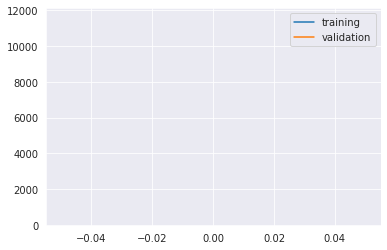

Epoch 2/25
31960/31960 [==============================] - trainLoss: 410.3439  Val_loss: 252.3412 
Epoch 3/25
31960/31960 [==============================] - trainLoss: 229.7653  Val_loss: 154.6894 
Epoch 4/25
31960/31960 [==============================] - trainLoss: 158.6560  Val_loss: 115.3791 


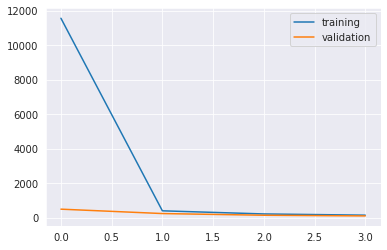

Epoch 5/25
31960/31960 [==============================] - trainLoss: 127.6525  Val_loss: 98.0121 
Epoch 6/25
31960/31960 [==============================] - trainLoss: 112.0557  Val_loss: 80.1149 
Epoch 7/25
31960/31960 [==============================] - trainLoss: 94.1811  Val_loss: 136.7949 


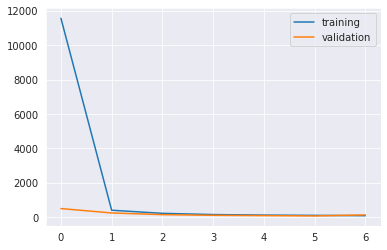

Epoch 8/25
31960/31960 [==============================] - trainLoss: 84.6109  Val_loss: 71.1780 
Epoch 9/25
31960/31960 [==============================] - trainLoss: 80.0661  Val_loss: 68.1989 
Epoch 10/25
31960/31960 [==============================] - trainLoss: 70.8862  Val_loss: 57.3498 


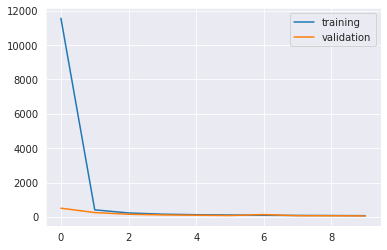

Epoch 11/25
31960/31960 [==============================] - trainLoss: 72.2998  Val_loss: 58.6978 
Epoch 12/25
31960/31960 [==============================] - trainLoss: 69.7865  Val_loss: 52.4342 
Epoch 13/25
31960/31960 [==============================] - trainLoss: 54.7845  Val_loss: 49.8650 


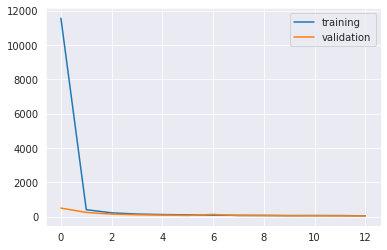

Epoch 14/25
31960/31960 [==============================] - trainLoss: 60.3476  Val_loss: 46.7356 
Epoch 15/25
31960/31960 [==============================] - trainLoss: 50.6894  Val_loss: 44.7222 
Epoch 16/25
31960/31960 [==============================] - trainLoss: 52.7332  Val_loss: 44.4737 


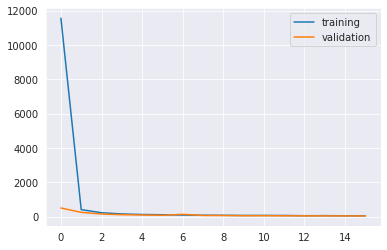

Epoch 17/25
31960/31960 [==============================] - trainLoss: 52.0273  Val_loss: 44.0813 
Epoch 18/25
31960/31960 [==============================] - trainLoss: 47.1657  Val_loss: 39.2437 
Epoch 19/25
31960/31960 [==============================] - trainLoss: 42.8903  Val_loss: 37.8396 


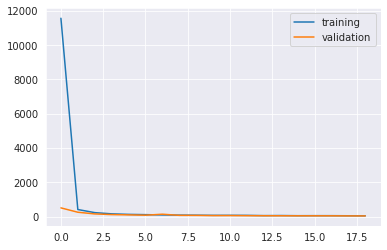

Epoch 20/25
31960/31960 [==============================] - trainLoss: 42.7166  Val_loss: 39.0298 
Epoch 21/25
31960/31960 [==============================] - trainLoss: 42.7827  Val_loss: 33.7131 
Epoch 22/25
31960/31960 [==============================] - trainLoss: 40.3632  Val_loss: 43.3185 


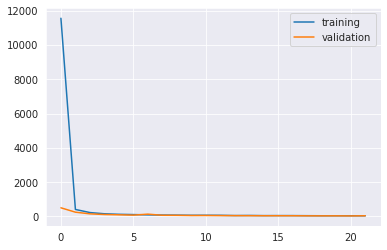

Epoch 23/25
31960/31960 [==============================] - trainLoss: 41.6379  Val_loss: 32.7627 
Epoch 24/25
31960/31960 [==============================] - trainLoss: 39.0374  Val_loss: 31.0292 
Epoch 25/25
31960/31960 [==============================] - trainLoss: 38.3564  Val_loss: 42.2471 


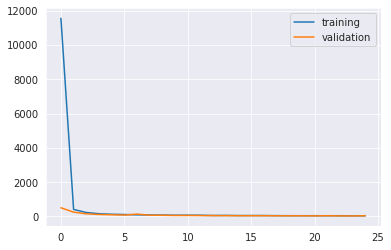

([<tf.Tensor: shape=(), dtype=float32, numpy=11560.696>,
  <tf.Tensor: shape=(), dtype=float32, numpy=410.34393>,
  <tf.Tensor: shape=(), dtype=float32, numpy=229.76534>,
  <tf.Tensor: shape=(), dtype=float32, numpy=158.65604>,
  <tf.Tensor: shape=(), dtype=float32, numpy=127.65246>,
  <tf.Tensor: shape=(), dtype=float32, numpy=112.05571>,
  <tf.Tensor: shape=(), dtype=float32, numpy=94.18114>,
  <tf.Tensor: shape=(), dtype=float32, numpy=84.61087>,
  <tf.Tensor: shape=(), dtype=float32, numpy=80.06606>,
  <tf.Tensor: shape=(), dtype=float32, numpy=70.88619>,
  <tf.Tensor: shape=(), dtype=float32, numpy=72.29978>,
  <tf.Tensor: shape=(), dtype=float32, numpy=69.78649>,
  <tf.Tensor: shape=(), dtype=float32, numpy=54.78451>,
  <tf.Tensor: shape=(), dtype=float32, numpy=60.347633>,
  <tf.Tensor: shape=(), dtype=float32, numpy=50.689373>,
  <tf.Tensor: shape=(), dtype=float32, numpy=52.733166>,
  <tf.Tensor: shape=(), dtype=float32, numpy=52.027325>,
  <tf.Tensor: shape=(), dtype=float32,

In [66]:
fit_model(train_nn_features,25,model,input_history,valid_history,valid_nn_features_tf,batch_size=64)

In [70]:
# h_encoder.save("h_encoder_final.h5")
# bi_rnn.save("bi_rnn_final.h5")
# h_encoder_first.save("h_encoder_first_final.h5")


# Check on importance sampler # 

This shows what the importance sampler does (encodes x,u to h such that the generator will decode x,h back to u).

In [33]:
h_encoder = keras.models.load_model("h_encoder_final.h5",custom_objects={
           "Sampling":Sampling})
bi_rnn = keras.models.load_model("bi_rnn_final.h5")
h_encoder_first = keras.models.load_model("h_encoder_first_final.h5",custom_objects={
           "Sampling":Sampling})


In [34]:
#encode seq

seq_to_test = train_nn_features[11:12,:,:]

h_sequence,h_mean_out_enc,h_log_var_out = sample_from_encoder(seq_to_test,h_encoder,h_encoder_first,
                                                    encoder_hidden_state_size,bi_rnn)


In [35]:
x_array =  seq_to_test[:,:-1,:1]
x_array_reshape = tf.reshape(x_array,(-1,1))
h_encoding_reshape = tf.reshape(h_mean_out_enc,(-1,h_shape))

In [36]:
#decode the mean
decoded_mean_u = generator([x_array_reshape,h_encoding_reshape])



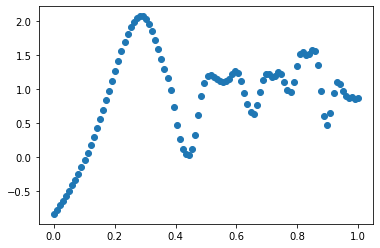

In [37]:
#plot of u_true against time 
plt.scatter(y=np.ravel(seq_to_test[:,:-1,1:]),x=np.linspace(0,1,100))

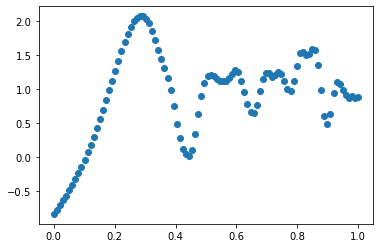

In [38]:
#plot of u against time after x and u summary have been encoded and then decoded using the gan. Good match to above. 
#The encoding models have carried out learning.
plt.scatter(y=np.ravel(decoded_mean_u),x=np.linspace(0,1,100))